# Imports

In [96]:
import torch
import numpy as np
from torchvision import transforms
from PIL import Image as PilImage

from omnixai.data.image import Image

from omnixai.explainers.vision.agnostic.shap import ShapImage
from omnixai.explainers.vision.specific.guided_bp import GuidedBP
from omnixai.explainers.vision.specific.ig import IntegratedGradientImage
from omnixai.explainers.vision.specific.scorecam.pytorch.scorecam import ScoreCAM
from omnixai.explainers.vision.specific.gradcam.pytorch.gradcam import GradCAM, GradCAMPlus, LayerCAM

from Exp.model import ResNet18, Vgg16
from xai_metrics import np2tensor, CausalMetric

In [97]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Explainable AI

In [98]:
hw_origin_path = "/home/vuong.nguyen/vuong/augmentare/Bias in EuroSAT/X_HW/Origin"

In [99]:
hw_origin = []
for id in range(30):
  img = PilImage.open(f"{hw_origin_path}/hw_{id+1}.png").convert('RGB')
  new_img = Image(img)
  hw_origin.append(new_img.to_numpy())

In [100]:
hw_origin = np.stack(hw_origin, axis=1).squeeze()

In [101]:
rv_origin_path = "/home/vuong.nguyen/vuong/augmentare/Bias in EuroSAT/X_RV/Origin"

In [102]:
rv_origin = []
for id in range(80):
  img = PilImage.open(f"{rv_origin_path}/rv_{id+1}.png").convert('RGB')
  new_img = Image(img)
  rv_origin.append(new_img.to_numpy())

In [103]:
rv_origin = np.stack(rv_origin, axis=1).squeeze()

In [104]:
bl_origin = np.concatenate((hw_origin , rv_origin), axis=0)

In [105]:
resnet18_model = ResNet18(2)
#resnet18_model.load_state_dict(torch.load(f"Exp/Output_ResNet18/Baseline/xai_checkpoint_baseline2.pt"))
#resnet18_model.load_state_dict(torch.load(f"Exp/Output_ResNet18/FDA/Aug/xai_checkpoint_augmentation_2.pt"))
#resnet18_model.load_state_dict(torch.load(f"Exp/Output_ResNet18/Flow/Aug/xai_checkpoint_augmentation_1.pt"))
#resnet18_model.load_state_dict(torch.load(f"Exp/Output_ResNet18/CCPL/Aug/xai_checkpoint_augmentation_2.pt"))
#resnet18_model.load_state_dict(torch.load(f"Exp/Output_ResNet18/DCGAN_FDA/Aug/xai_checkpoint_augmentation_1.pt"))
resnet18_model.load_state_dict(torch.load(f"Exp/Output_ResNet18/DCGAN_Flow/Aug/xai_checkpoint_augmentation_1.pt"))

<All keys matched successfully>

## Inputs

In [106]:
trans_pred = transforms.Compose([
    transforms.Resize(64)
])

In [107]:
inputs = bl_origin
inputs = np2tensor(inputs)
inputs = inputs/255
inputs = trans_pred(inputs)

## Mask

In [108]:
trans_mask = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor()
])

preprocess = lambda ims: torch.stack([trans_mask(im.to_pil()) for im in ims])

postprocess = lambda logits: torch.nn.functional.softmax(logits, dim=1)

In [109]:
bl_origin = Image(
    data=bl_origin,
    batched=True
)

### Grad CAM

In [110]:
explainer = GradCAM(
    model=resnet18_model,
    target_layer=resnet18_model.extractor[-3][0],
    preprocess_function=preprocess,
    mode="classification"
)

explanations_grad_cam = explainer.explain(bl_origin)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


There are too many instances (110 > 10), so only the first 10 instances are plotted.


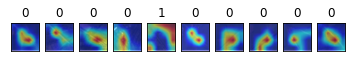

In [111]:
explanations_grad_cam.plot()

### Grad CAM Plus

In [112]:
explainer = GradCAMPlus(
    model=resnet18_model,
    target_layer=resnet18_model.extractor[-3][0],
    preprocess_function=preprocess,
    mode="classification"
)

explanations_grad_cam_plus = explainer.explain(bl_origin)

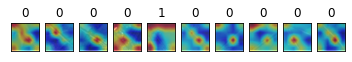

In [113]:
explanations_grad_cam_plus.plot()

### Layer CAM

In [114]:
explainer = LayerCAM(
    model=resnet18_model,
    target_layer=resnet18_model.extractor[-3][0],
    preprocess_function=preprocess,
    mode="classification"
)

explanations_layer_cam = explainer.explain(bl_origin)

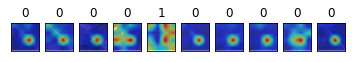

In [115]:
explanations_layer_cam.plot()

### Score CAM

In [116]:
explainer = ScoreCAM(
    model=resnet18_model,
    target_layer=resnet18_model.extractor[-3][0],
    preprocess_function=preprocess,
    mode="classification"
)

explanations_score_cam = explainer.explain(bl_origin)

100%|██████████| 256/256 [00:11<00:00, 23.06it/s]


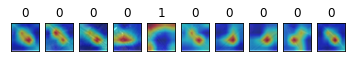

In [117]:
explanations_score_cam.plot()

### Integrated Gradient

In [118]:
explainer = IntegratedGradientImage(
    model=resnet18_model,
    preprocess_function=preprocess,
    mode="classification"
)

explanations_ig = explainer.explain(bl_origin)

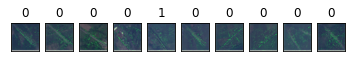

In [119]:
explanations_ig.plot()

### Guided Back Propagation

In [120]:
explainer = GuidedBP(
    model=resnet18_model,
    preprocess_function=preprocess,
    mode="classification"
)

explanations_guidedbp = explainer.explain(bl_origin)

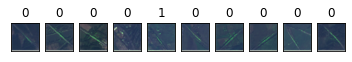

In [121]:
explanations_guidedbp.plot()

### Shap

In [122]:
explainer = ShapImage(
    model=resnet18_model,
    preprocess_function=preprocess,
    mode="classification"
)

explanations_shap = explainer.explain(bl_origin)

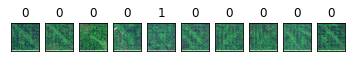

In [123]:
explanations_shap.plot()

## Get explainations

In [124]:
exs_grad_cam = explanations_grad_cam.get_explanations()
exs_grad_cam_plus = explanations_grad_cam_plus.get_explanations()
exs_layer_cam = explanations_layer_cam.get_explanations()
exs_score_cam = explanations_score_cam.get_explanations()

exs_ig = explanations_ig.get_explanations()
exs_guidedbp = explanations_guidedbp.get_explanations()
exs_shap = explanations_shap.get_explanations()

In [125]:
def get_mask_pred(exs):
    mask = []
    for i in range(len(exs)):
        sub_mask = exs[i]["scores"]
        if sub_mask.ndim == 3:
            sub_mask = np.mean(sub_mask, axis=-1)
        mask.append(sub_mask)
    return mask

In [126]:
grad_cam_mask = get_mask_pred(exs_grad_cam)
grad_cam_plus_mask = get_mask_pred(exs_grad_cam_plus)

layer_cam_mask = get_mask_pred(exs_layer_cam)
score_cam_mask = get_mask_pred(exs_score_cam)

ig_mask = get_mask_pred(exs_ig)
guidedbp_mask = get_mask_pred(exs_guidedbp)
shap_mask = get_mask_pred(exs_shap)

In [127]:
grad_cam_mask = np.stack(grad_cam_mask, axis=0)
grad_cam_plus_mask = np.stack(grad_cam_plus_mask, axis=0)
layer_cam_mask = np.stack(layer_cam_mask, axis=0)
score_cam_mask = np.stack(score_cam_mask, axis=0)

ig_mask = np.stack(ig_mask, axis=0)
guidedbp_mask = np.stack(guidedbp_mask, axis=0)
shap_mask = np.stack(shap_mask, axis=0)

In [128]:
grad_cam_mask = torch.from_numpy(grad_cam_mask)
grad_cam_plus_mask = torch.from_numpy(grad_cam_plus_mask)
layer_cam_mask = torch.from_numpy(layer_cam_mask)
score_cam_mask = torch.from_numpy(score_cam_mask)
ig_mask = torch.from_numpy(ig_mask)
guidedbp_mask = torch.from_numpy(guidedbp_mask)
shap_mask = torch.from_numpy(shap_mask)

## Evaluations

In [129]:
def get_list_metrics(model, inputs, mask, mode, steps):
    list_scores = []
    preds = []

    if mode == "deletion":
        deletion = CausalMetric(model, 'del', steps)
        for i in range(len(inputs)):
            img = inputs[i].unsqueeze(0)
            sub_mask = mask[i].unsqueeze(0)
            h, c = deletion.single_run(img, sub_mask)
            list_scores.append(h)
            preds.append(c)

    elif mode == "insertion":
        insertion = CausalMetric(model, 'ins', steps)
        for i in range(len(inputs)):
            img = inputs[i].unsqueeze(0)
            sub_mask = mask[i].unsqueeze(0)
            h, c = insertion.single_run(img, sub_mask)
            list_scores.append(h)
            preds.append(c)

    return list_scores, preds

In [130]:
grad_cam_del_dcgan_flow, preds = get_list_metrics(resnet18_model, inputs, grad_cam_mask, "deletion", 64)

grad_cam_plus_del_dcgan_flow, _ = get_list_metrics(resnet18_model, inputs, grad_cam_plus_mask, "deletion", 64)

layer_cam_del_dcgan_flow, _ = get_list_metrics(resnet18_model, inputs, layer_cam_mask, "deletion", 64)

score_cam_del_dcgan_flow, _ = get_list_metrics(resnet18_model, inputs, score_cam_mask, "deletion", 64)

ig_del_dcgan_flow, _ = get_list_metrics(resnet18_model, inputs, ig_mask, "deletion", 64)

guidedbp_del_dcgan_flow, _ = get_list_metrics(resnet18_model, inputs, guidedbp_mask, "deletion", 64)

shap_del_dcgan_flow, _ = get_list_metrics(resnet18_model, inputs, shap_mask, "deletion", 64)

In [131]:
grad_cam_ins_dcgan_flow, _ = get_list_metrics(resnet18_model, inputs, grad_cam_mask, "insertion", 64)

grad_cam_plus_ins_dcgan_flow, _ = get_list_metrics(resnet18_model, inputs, grad_cam_plus_mask, "insertion", 64)

layer_cam_ins_dcgan_flow, _ = get_list_metrics(resnet18_model, inputs, layer_cam_mask, "insertion", 64)

score_cam_ins_dcgan_flow, _ = get_list_metrics(resnet18_model, inputs, score_cam_mask, "insertion", 64)

ig_ins_dcgan_flow, _ = get_list_metrics(resnet18_model, inputs, ig_mask, "insertion", 64)

guidedbp_ins_dcgan_flow, _ = get_list_metrics(resnet18_model, inputs, guidedbp_mask, "insertion", 64)

shap_ins_dcgan_flow, _ = get_list_metrics(resnet18_model, inputs, shap_mask, "insertion", 64)

In [132]:
save_folder_path = "/home/vuong.nguyen/vuong/augmentare/Bias in EuroSAT/XAI/ResNet18"

In [133]:
pred = np.stack(preds, axis=0)

In [134]:
np.save(f"{save_folder_path}/pred_dcgan_flow.npy", pred)

In [135]:
np.save(f"{save_folder_path}/grad_cam_del_dcgan_flow.npy", grad_cam_del_dcgan_flow)
np.save(f"{save_folder_path}/grad_cam_plus_del_dcgan_flow.npy", grad_cam_plus_del_dcgan_flow)
np.save(f"{save_folder_path}/layer_cam_del_dcgan_flow.npy", layer_cam_del_dcgan_flow)
np.save(f"{save_folder_path}/score_cam_del_dcgan_flow.npy", score_cam_del_dcgan_flow)
np.save(f"{save_folder_path}/ig_del_dcgan_flow.npy", ig_del_dcgan_flow)
np.save(f"{save_folder_path}/guidedbp_del_dcgan_flow.npy", guidedbp_del_dcgan_flow)
np.save(f"{save_folder_path}/shap_del_dcgan_flow.npy", shap_del_dcgan_flow)

In [136]:
np.save(f"{save_folder_path}/grad_cam_ins_dcgan_flow.npy", grad_cam_ins_dcgan_flow)
np.save(f"{save_folder_path}/grad_cam_plus_ins_dcgan_flow.npy", grad_cam_plus_ins_dcgan_flow)
np.save(f"{save_folder_path}/layer_cam_ins_dcgan_flow.npy", layer_cam_ins_dcgan_flow)
np.save(f"{save_folder_path}/score_cam_ins_dcgan_flow.npy", score_cam_ins_dcgan_flow)
np.save(f"{save_folder_path}/ig_ins_dcgan_flow.npy", ig_ins_dcgan_flow)
np.save(f"{save_folder_path}/guidedbp_ins_dcgan_flow.npy", guidedbp_ins_dcgan_flow)
np.save(f"{save_folder_path}/shap_ins_dcgan_flow.npy", shap_ins_dcgan_flow)

## Tests

In [137]:
insertion = CausalMetric(resnet18_model, 'ins', 64)
deletion = CausalMetric(resnet18_model, 'del', 64)

In [138]:
image_path = "/home/vuong.nguyen/vuong/augmentare/Bias in EuroSAT/XAI_Output/ResNet18/dcgan_flow"

In [139]:
pred

array([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [140]:
def get_images(id, inputs, path, type = "bon", type_img = "hw"):
    mask = [grad_cam_mask, grad_cam_plus_mask, layer_cam_mask, score_cam_mask, ig_mask, guidedbp_mask, shap_mask]
    file_name = ["grad_cam", "grad_cam_plus", "layer_cam", "score_cam", "ig", "guidedbp", "shap"]
    i = 0
    for mas in mask:
        img = inputs[id].unsqueeze(0)
        sub_mask = mas[id].unsqueeze(0)
        if type == "bon":
            if type_img == "hw":
                new_path_del = f"{path}/del_bon_hw_{file_name[i]}.png"
                new_path_ins = f"{path}/ins_bon_hw_{file_name[i]}.png"
            elif type_img == "rv":
                new_path_del = f"{path}/del_bon_rv_{file_name[i]}.png"
                new_path_ins = f"{path}/ins_bon_rv_{file_name[i]}.png"

        elif type == "mau":
            if type_img == "hw":
                new_path_del = f"{path}/del_mau_hw_{file_name[i]}.png"
                new_path_ins = f"{path}/ins_mau_hw_{file_name[i]}.png"
            elif type_img == "rv":
                new_path_del = f"{path}/del_mau_rv_{file_name[i]}.png"
                new_path_ins = f"{path}/ins_mau_rv_{file_name[i]}.png"

        _, _= deletion.single_run(img, sub_mask, verbose=1, path=new_path_del)
        _, _ = insertion.single_run(img, sub_mask, verbose=1, path=new_path_ins)
        i += 1

### Good prediction HW

In [149]:
img = inputs[3].unsqueeze(0)
sub_mask = grad_cam_mask[3].unsqueeze(0)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


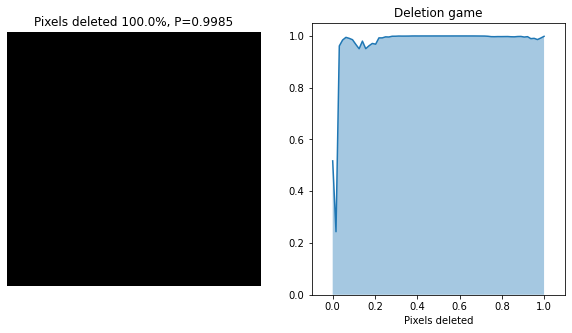

In [150]:
h, c = deletion.single_run(img, sub_mask, verbose=1)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


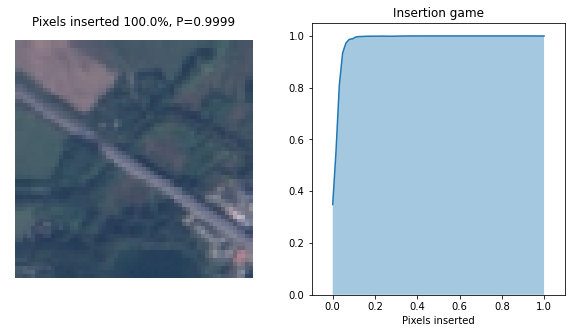

In [147]:
h, c = insertion.single_run(img, sub_mask, verbose=1)

In [ ]:
get_images(3, inputs, image_path, "mau", "hw")

### Good prediction RV

In [154]:
img = inputs[44].unsqueeze(0)
sub_mask = grad_cam_mask[44].unsqueeze(0)

In [ ]:
h, c = deletion.single_run(img, sub_mask, verbose=1)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


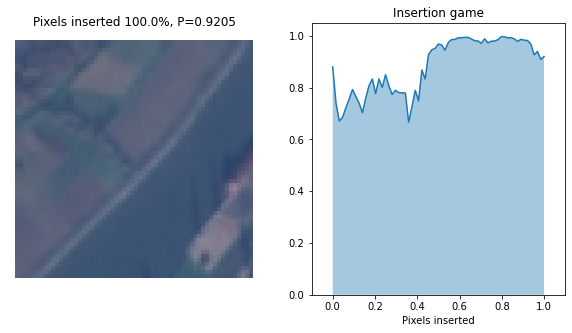

In [91]:
h, c = insertion.single_run(img, sub_mask, verbose=1)

In [117]:
h, c

(0.9137686296598986, 1)

In [ ]:
get_images(44, inputs, image_path, "mau", "rv")